Before generating the first figures, run the cells below to import everything we need and set up matplolib.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator

In [2]:
plt.style.use(r"figures.mplstyle")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
   new_cmap = colors.LinearSegmentedColormap.from_list(
      'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
      cmap(np.linspace(minval, maxval, n)))
   return new_cmap

colors = plt.cm.tab20(np.linspace(0,1,20))

# Plot settings
DPI=600
fig_width_pt = 450  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean # height in inches
x_lim = [1994, 2022]

First we want to display how many stocks are eligible when we look at the citerions separately.

In [3]:
# Read dataframes and do some counting

def unusableReturns(ric, year):
    selection = df_returns[ric][(df_returns.index >= f"{year}-01-01") & (df_returns.index <= f"{year}-12-31")]
    return bool(selection.isna().values.any())

df_market_cap = pd.read_pickle("UsableData/MarketCap.pkl")
df_employees = pd.read_pickle("UsableData/Employees.pkl")
df_book_value = pd.read_pickle("UsableData/BookValue.pkl")
df_returns = pd.read_pickle("UsableData/Returns.pkl").T
df_eligible = pd.read_pickle("UsableData/EligibleStocks.pkl")
df_raw = pd.read_csv("RawData/FirmData.csv")
df_raw["Year"] = pd.to_datetime(df_raw["Date"], dayfirst=True).dt.year
df_raw = df_raw.pivot(index="RIC", columns="Year", values="Total Equity")

x = df_eligible.columns.to_list()
y_MC = np.zeros(len(x))
y_EMP = np.zeros(len(x))
y_BV = np.zeros(len(x))
y_RT = np.zeros(len(x))
y_EL = np.zeros(len(x))
y_Ref = np.full(len(x), len(df_raw.index))

for year in x:
    df = df_eligible[df_eligible[year] == True]
    i = x.index(year)
    y_EL[i] = len(df.index)
for ric in df_market_cap.index:
    for year in x:
        mc = df_market_cap.loc[ric, year]
        emp = df_employees.loc[ric, year]
        bv = df_book_value.loc[ric, year]
        i = x.index(year)
        if not math.isnan(mc):
            y_MC[i] +=1
        if not math.isnan(emp):
            y_EMP[i] += 1
        if not math.isnan(bv):
            y_BV[i] += 1
        if not unusableReturns(ric, year):
            y_RT[i] += 1

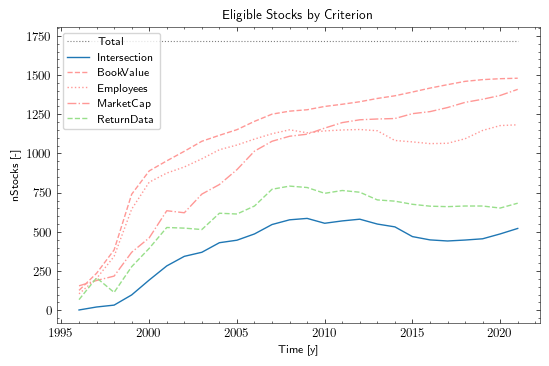

In [4]:
# Plot number of eligible stocks by criterion

fig = plt.figure(figsize = (fig_width, fig_height))

plt.plot(x, y_Ref, label="Total", color= colors[14], linestyle="dotted", linewidth=0.8)
plt.plot(x, y_EL, label="Intersection", color = colors[0])
plt.plot(x, y_BV, label="BookValue", color = colors[7], linestyle="dashed")
plt.plot(x, y_EMP, label="Employees", color = colors[7], linestyle="dotted")
plt.plot(x, y_MC, label="MarketCap", color = colors[7], linestyle="dashdot")
plt.plot(x, y_RT, label="ReturnData", color = colors[5], linestyle="dashed")

plt.title("Eligible Stocks by Criterion")
plt.xlabel("Time [y]")
plt.ylabel("nStocks [-]")
plt.legend(loc="upper left")

plt.savefig('Figures/nStocks.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/nStocks.pdf', pad_inches = .1, bbox_inches = 'tight')

Compare raw return data to filtered return data to see the effects of the outlier detection

In [5]:
# Read and prepare dataframes
df_returns = pd.read_pickle("UsableData/Returns.pkl")
returns_flat = df_returns.T.to_numpy().flatten()
returns_flat = returns_flat[~np.isnan(returns_flat)]

df_raw = pd.read_csv('RawData/Returns.csv', index_col="RIC")
df_raw.columns = pd.to_datetime(df_raw.columns, dayfirst=True)
raw_flat = df_raw.T.to_numpy().flatten()
raw_flat = raw_flat[~np.isnan(raw_flat)]

E = [raw_flat, returns_flat]

In [6]:
# Implement custom tick locator to display minor ticks in linear and logarithmic part of y-axis
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

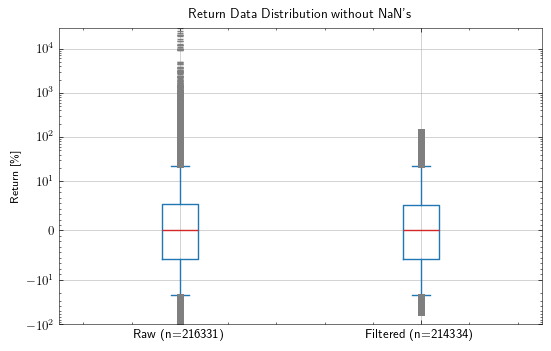

In [7]:
# Plot boxplot

fig = plt.figure(figsize = (fig_width, fig_height))
plt.yscale('symlog', subs=(np.arange(4)+1)*2, linthresh=10, linscale=1.0)
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1))
plt.ylim([-100, 30000])

boxprops = dict(color=colors[0])
flierprops = dict(marker='_', markerfacecolor=colors[14], markersize=5,
                  markeredgecolor=colors[14])
medianprops = dict(color=colors[6])
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
whiskerprops = dict(color=colors[0])

plot = plt.boxplot(E, labels=(f"Raw (n={len(raw_flat)})", f"Filtered (n={len(returns_flat)})"), boxprops=boxprops, flierprops=flierprops, whiskerprops=whiskerprops, capprops=whiskerprops, medianprops=medianprops)
plt.ylabel("Return [\%]")
plt.title("Return Data Distribution without NaN's")
plt.grid()

plt.savefig('Figures/ReturnsComparison.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/ReturnsComparison.pdf', pad_inches = .1, bbox_inches = 'tight')


Plot simulation results

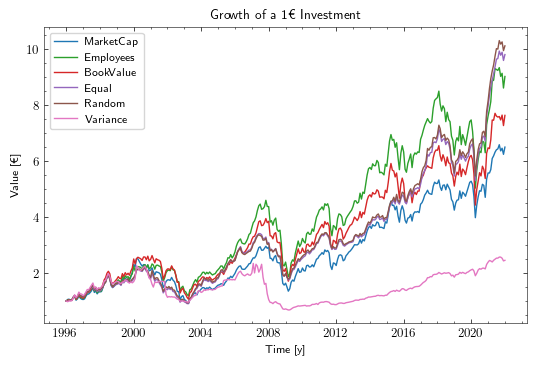

In [8]:
# Plot results
df_results = pd.read_pickle("UsableData/Results.pkl")

fig = plt.figure(figsize = (fig_width, fig_height))

plt.plot(df_results["Market Cap"], label="MarketCap", color=colors[0])
plt.plot(df_results["Employees"], label="Employees", color=colors[4])
plt.plot(df_results["Book Value"], label="BookValue", color=colors[6])
plt.plot(df_results["Equal"], label="Equal", color=colors[8])
plt.plot(df_results["Random"], label="Random", color=colors[10])
plt.plot(df_results["Variance"], label="Variance", color=colors[12])

plt.title("Growth of a 1€ Investment")
plt.ylabel("Value [€]")
plt.xlabel("Time [y]")
plt.legend()

plt.savefig('Figures/Results.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/Results.pdf', pad_inches = .1, bbox_inches = 'tight')